# Plot the results (Daedalus pipeline) on maps

Before running this notebook, you need to run a simulation using `Daedalus` library. Please refer to [README](https://github.com/BenjaminIsaac0111/daedalus/blob/feature/refactoring_pipeline/README.md), Section: `Run Daedalus via command line`. After running the simulation, an `output` directory is created with the following structure:

```bash
output
└── E08000032
    ├── config_file_E08000032.yml
    ├── ssm_E08000032_MSOA11_ppp_2011_processed.csv
    └── ssm_E08000032_MSOA11_ppp_2011_simulation.csv
```

Here, we will plot the results stored in these files on maps.

**WARNING**

We use the `cartopy` library to plot maps in this notebook. `cartopy` is not installed by default. Please follow the instructions here:

https://scitools.org.uk/cartopy/docs/latest/installing.html

and make sure that `cartopy` can be imported in the following cell:

In [1]:
import cartopy.crs as ccrs

In [2]:
import datetime
import matplotlib.pyplot as plt
from pyproj import Transformer
import pandas as pd

## Migrants pool

In [3]:
pop = pd.read_csv('../output/E08000032/ssm_E08000032_MSOA11_ppp_2011_simulation.csv')
print(f"Number of rows: {len(pop)}")
pop.head()

Number of rows: 538244


/Users/khosseini/myJobs/ATI/Projects/2019/SPENCER/vivarium_public_health_spenser/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,tracked,immigrated,emigrated,years_of_life_lost,cause_of_death,previous_LAD_locations,previous_MSOA_locations,internal_outmigration,last_outmigration_time,alive,location,sex,ethnicity,age,entrance_time,exit_time,MSOA,last_birth_time,parent_id
0,0,True,no_immigration,no_emigration,0.0,not_dead,NaN,NaN,No,NaN,alive,E08000032,1.0,WBI,2.013699,2010-12-22 00:00:00,NaN,E02002183,NaN,-1
1,1,True,no_immigration,no_emigration,0.0,not_dead,NaN,NaN,No,NaN,alive,E08000032,1.0,WBI,2.013699,2010-12-22 00:00:00,NaN,E02002183,NaN,-1
2,2,True,no_immigration,no_emigration,0.0,not_dead,NaN,NaN,No,NaN,alive,E08000032,1.0,WBI,2.013699,2010-12-22 00:00:00,NaN,E02002183,NaN,-1
3,3,True,no_immigration,no_emigration,0.0,not_dead,NaN,NaN,No,NaN,alive,E08000032,1.0,WBI,2.013699,2010-12-22 00:00:00,NaN,E02002183,NaN,-1
4,4,True,no_immigration,no_emigration,0.0,not_dead,NaN,NaN,No,NaN,alive,E08000032,1.0,WBI,2.013699,2010-12-22 00:00:00,NaN,E02002183,NaN,-1


In [4]:
migrant_pool = pop[pop['internal_outmigration'] == 'Yes']


## Prepare lat/lon of MSOAs

In [5]:
transformer = Transformer.from_crs('EPSG:27700', 'EPSG:4326')

def calcLatLon(row, transformer):
    return transformer.transform(row["X"], row["Y"])

In [6]:
# read centroid file
msoa_centroids = pd.read_csv("../persistent_data/Middle_Layer_Super_Output_Areas__December_2011__Population_Weighted_Centroids.csv")

In [7]:
# Calculate coordinates based on centroid file
msoa_centroids["coord"] = \
        msoa_centroids.apply(calcLatLon, transformer=transformer, axis=1)
msoa_centroids[["lat", "lon"]] = \
        pd.DataFrame(msoa_centroids['coord'].to_list(), columns=["lat", "lon"])

In [8]:
msoa_centroids.head()

,X,Y,objectid,msoa11cd,msoa11nm,coord,lat,lon
0,445583.305,524174.111,1,E02002536,Stockton-on-Tees 002,"(54.610678648429214, -1.2957586099395257)",54.610679,-1.295759
1,446778.119,524255.508,2,E02002537,Stockton-on-Tees 003,"(54.61130112046631, -1.2772482026067749)",54.611301,-1.277248
2,461357.951,515117.478,3,E02002534,Redcar and Cleveland 020,"(54.52763345733948, -1.053442127901051)",54.527633,-1.053442
3,446118.000,525454.530,4,E02002535,Stockton-on-Tees 001,"(54.62213612007939, -1.2872797688114057)",54.622136,-1.287280
4,461054.231,516173.954,5,E02002532,Redcar and Cleveland 018,"(54.5371631872312, -1.0579158114403322)",54.537163,-1.057916


In [9]:
# Previous MSOA
migrant_pool[["prev_MSOA_lat", "prev_MSOA_lon"]] = \
            migrant_pool[["previous_MSOA_locations"]].merge(msoa_centroids[["msoa11cd", "lat", "lon"]], 
                                                            left_on="previous_MSOA_locations", 
                                                            right_on="msoa11cd")[["lat", "lon"]]

/Users/khosseini/myJobs/ATI/Projects/2019/SPENCER/vivarium_public_health_spenser/venv/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [10]:
# Current MSOA
migrant_pool[["MSOA_lat", "MSOA_lon"]] = \
            migrant_pool[["MSOA"]].merge(msoa_centroids[["msoa11cd", "lat", "lon"]], 
                                                         left_on="MSOA", 
                                                         right_on="msoa11cd")[["lat", "lon"]]

In [11]:
migrant_pool.head()

,Unnamed: 0,tracked,immigrated,emigrated,years_of_life_lost,cause_of_death,previous_LAD_locations,previous_MSOA_locations,internal_outmigration,last_outmigration_time,...,age,entrance_time,exit_time,MSOA,last_birth_time,parent_id,prev_MSOA_lat,prev_MSOA_lon,MSOA_lat,MSOA_lon
8,8,True,no_immigration,no_emigration,0.0,not_dead,E08000032,E02002183,Yes,2011-06-30 00:00:00,...,2.013699,2010-12-22 00:00:00,NaN,E02002184,NaN,-1,53.94244,-1.880144,53.92597,-1.818507
15,15,True,no_immigration,no_emigration,0.0,not_dead,E08000032,E02002183,Yes,2012-01-06 00:00:00,...,2.013699,2010-12-22 00:00:00,NaN,E02002184,NaN,-1,53.94244,-1.880144,53.92597,-1.818507
21,21,True,no_immigration,no_emigration,0.0,not_dead,E08000032,E02002183,Yes,2011-09-08 00:00:00,...,3.013699,2010-12-22 00:00:00,NaN,E02002184,NaN,-1,53.94244,-1.880144,53.92597,-1.818507
45,45,True,no_immigration,no_emigration,0.0,not_dead,E08000032,E02002183,Yes,2011-01-21 00:00:00,...,4.013699,2010-12-22 00:00:00,NaN,E02002184,NaN,-1,53.94244,-1.880144,53.92597,-1.818507
85,85,True,no_immigration,no_emigration,0.0,not_dead,E08000032,E02002183,Yes,2011-06-20 00:00:00,...,5.013699,2010-12-22 00:00:00,NaN,E02002184,NaN,-1,53.94244,-1.880144,53.92597,-1.818507


## Plots

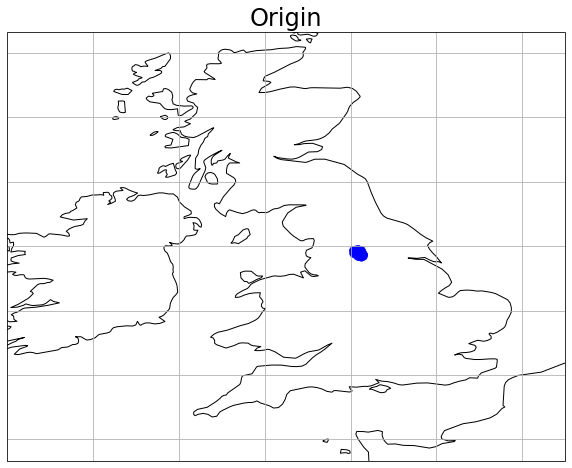

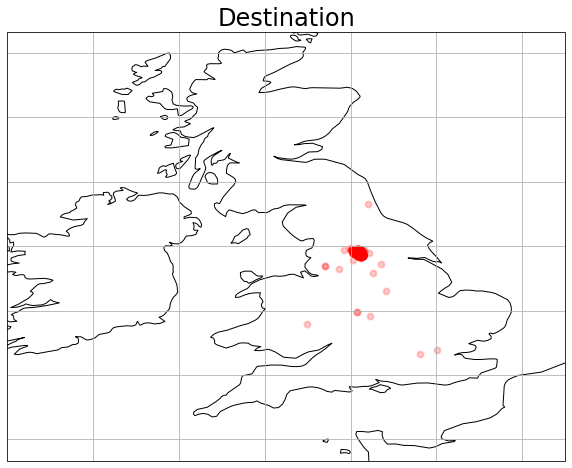

In [12]:
uk_extent = [-10, 3, 49, 59]
plain_crs = ccrs.PlateCarree()

plt.figure(figsize=(10, 20))
ax = plt.axes(projection=plain_crs)
ax.coastlines(resolution='50m')
ax.gridlines()
ax.set_extent(uk_extent, crs=plain_crs)

ax.scatter(migrant_pool["prev_MSOA_lon"],
           migrant_pool["prev_MSOA_lat"],
           color='blue', linewidth=2, 
           marker='o', alpha=0.2,
           transform=plain_crs)
plt.title("Origin", size=24)

plt.figure(figsize=(10, 20))
ax = plt.axes(projection=plain_crs)
ax.coastlines(resolution='50m')
ax.gridlines()
ax.set_extent(uk_extent, crs=plain_crs)

ax.scatter(migrant_pool["MSOA_lon"],
           migrant_pool["MSOA_lat"],
           color='red', linewidth=2, 
           marker='o', alpha=0.2,
           transform=plain_crs)
plt.title("Destination", size=24)

plt.show()

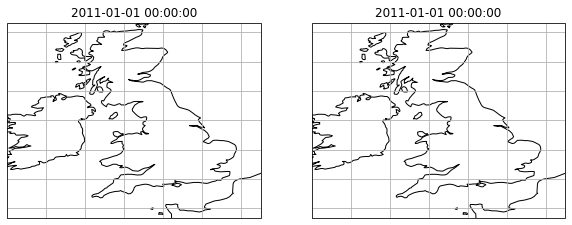

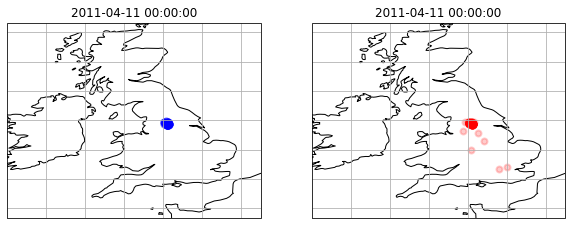

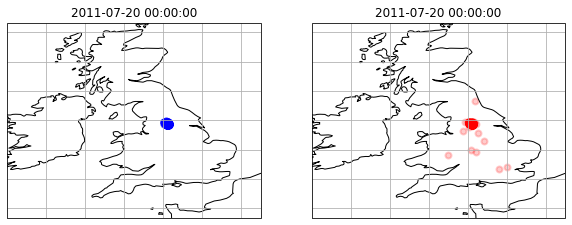

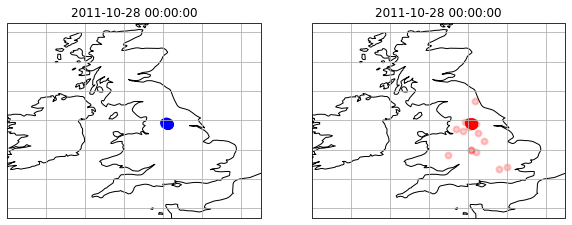

In [13]:
# --- input
min_time = "2011-01-01"
max_time = datetime.datetime.strptime("2011-12-31", "%Y-%m-%d")
# intervals for plotting (in days)
interval_in_days = 100
uk_extent = [-10, 3, 49, 59]
# ---

plain_crs = ccrs.PlateCarree()
curr_time = datetime.datetime.strptime(min_time, "%Y-%m-%d")
time_axis = []

while curr_time <= max_time:
    time_axis.append(curr_time)
    
    migrant_pool_curr = migrant_pool[migrant_pool["last_outmigration_time"] <= curr_time.strftime("%Y-%m-%d")]

    plt.figure(figsize=(10, 20))
    ax = plt.subplot(1, 2, 1, projection=plain_crs)
    ax.coastlines(resolution='50m')
    ax.gridlines()
    ax.set_extent(uk_extent, crs=plain_crs)
    
    ax.scatter(migrant_pool_curr["prev_MSOA_lon"],
           migrant_pool_curr["prev_MSOA_lat"],
           color='blue', linewidth=2, 
           marker='o', alpha=0.2,
           transform=plain_crs)
    plt.title(curr_time)
    
    ax = plt.subplot(1, 2, 2, projection=plain_crs)
    ax.coastlines(resolution='50m')
    ax.gridlines()
    ax.set_extent(uk_extent, crs=plain_crs)
    ax.scatter(migrant_pool_curr["MSOA_lon"],
           migrant_pool_curr["MSOA_lat"],
           color='red', linewidth=2, 
           marker='o', alpha=0.2,
           transform=plain_crs)
    plt.title(curr_time)
    
    plt.show()
    
    # go to next time, according to the selected interval_in_days
    curr_time = datetime.datetime.strptime(curr_time.strftime("%Y-%m-%d"), "%Y-%m-%d")
    curr_time += datetime.timedelta(days=interval_in_days)

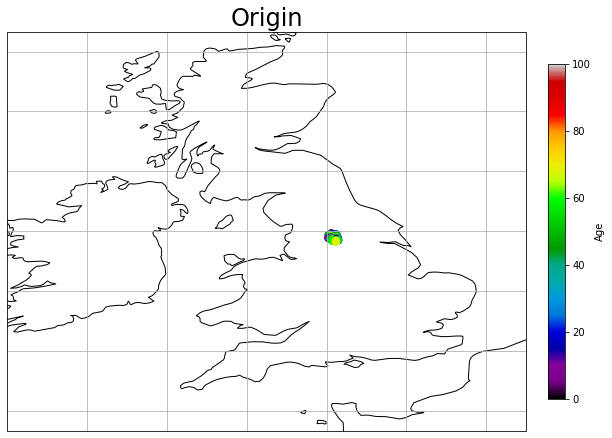

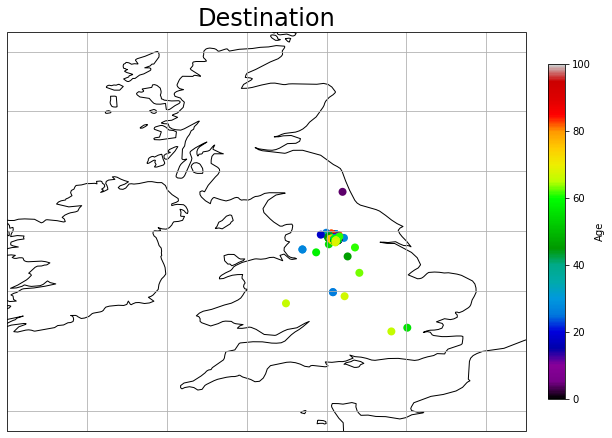

In [14]:
uk_extent = [-10, 3, 49, 59]
plain_crs = ccrs.PlateCarree()
cm = plt.cm.get_cmap('nipy_spectral')

plt.figure(figsize=(10, 20))
ax = plt.axes(projection=plain_crs)
ax.coastlines(resolution='50m')
ax.gridlines()
ax.set_extent(uk_extent, crs=plain_crs)

# Color with age, origin
sc = ax.scatter(migrant_pool["prev_MSOA_lon"],
           migrant_pool["prev_MSOA_lat"],
           c=migrant_pool["age"], 
           linewidth=2, marker='o',
           cmap=cm,
           vmin=0, vmax=100,
           transform=plain_crs)
cbar = plt.colorbar(sc, fraction=0.03, pad=0.04)
cbar.set_label("Age")
plt.title("Origin", size=24)

# Color with age, destination
plt.figure(figsize=(10, 20))
ax = plt.axes(projection=plain_crs)
ax.coastlines(resolution='50m')
ax.gridlines()
ax.set_extent(uk_extent, crs=plain_crs)

ax.scatter(migrant_pool["MSOA_lon"],
           migrant_pool["MSOA_lat"],
           c=migrant_pool["age"], 
           linewidth=2, marker='o',
           cmap=cm,
           vmin=0, vmax=100,
           transform=plain_crs,
           )
cbar = plt.colorbar(sc, fraction=0.03, pad=0.04)
cbar.set_label("Age")
plt.title("Destination", size=24)

plt.show()


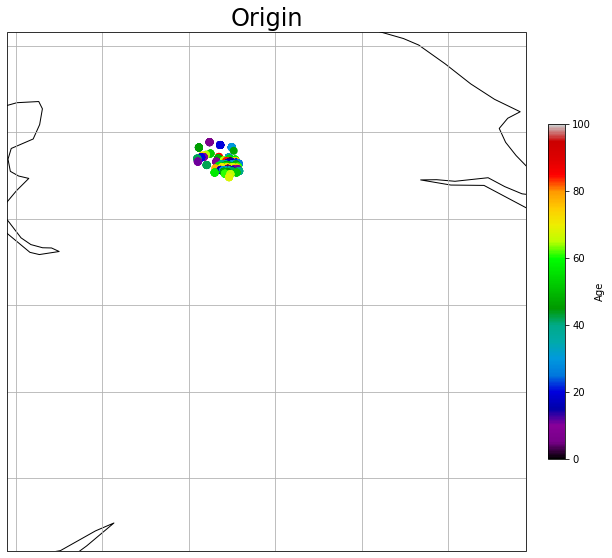

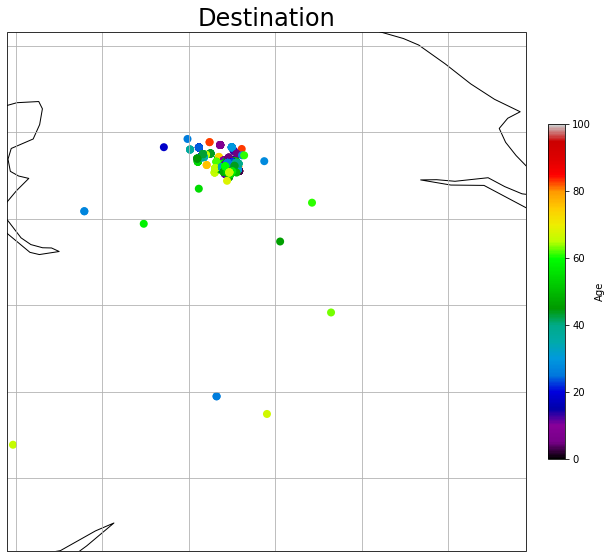

In [15]:
# Save as above, zoomed in
plain_crs = ccrs.PlateCarree()
cm = plt.cm.get_cmap('nipy_spectral')

dx = dy = 1.5
uk_extent = [-1.55-dx, -1.55+dx, 53.08-dy, 53.08+dy]

plt.figure(figsize=(10, 20))
ax = plt.axes(projection=plain_crs)
ax.coastlines(resolution='50m')
ax.gridlines()
ax.set_extent(uk_extent, crs=plain_crs)

sc = ax.scatter(migrant_pool["prev_MSOA_lon"],
           migrant_pool["prev_MSOA_lat"],
           c=migrant_pool["age"], 
           linewidth=2, marker='o',
           cmap=cm,
           vmin=0, vmax=100,
           transform=plain_crs,
           )
cbar = plt.colorbar(sc, fraction=0.03, pad=0.04)
cbar.set_label("Age")
plt.title("Origin", size=24)

plt.figure(figsize=(10, 20))
ax = plt.axes(projection=plain_crs)
ax.coastlines(resolution='50m')
ax.gridlines()
ax.set_extent(uk_extent, crs=plain_crs)

ax.scatter(migrant_pool["MSOA_lon"],
           migrant_pool["MSOA_lat"],
           c=migrant_pool["age"], 
           linewidth=2, marker='o',
           cmap=cm,
           vmin=0, vmax=100,
           transform=plain_crs,
           )
cbar = plt.colorbar(sc, fraction=0.03, pad=0.04)
cbar.set_label("Age")
plt.title("Destination", size=24)

plt.show()